Camacho Castelan Jose Manuel
S22002245

In [245]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import igraph
from igraph import Graph, EdgeSeq
import plotly.graph_objects as go
import math
import random

In [246]:
mov = 0.5 # tamanio de paso del robot
expandidos = []

origen = [5,0]
meta = [8,8]

In [247]:
def dibujar(gp):
    plt.grid(True)
    plt.scatter(gp[0], gp[1], c="r") # dibula la posicion del punto
    plt.plot([0,0,10, 10,0], [0,10,10,0,0], c="k") # dibujamos un cuadro delimitando el espacio de trabajo

In [248]:
class Obstaculo():
    def __init__(self, v1, v2):
        self.v1 = v1 # esquina superior
        self.v2 = v2 # esquina inferior

    def en_colision(self, punto):
        if self.v1[0] <= punto[0] <= self.v2[0] and self.v2[1] <= punto[1] <= self.v1[1]:
            return True
        return False
    
    def dibuja(self):
        x = [self.v1[0], self.v2[0], self.v2[0], self.v1[0], self.v1[0]]
        y = [self.v1[1], self.v1[1], self.v2[1], self.v2[1], self.v1[1]]
        plt.plot(x,y, "--k")

In [249]:
obstaculos = [
    Obstaculo([6,7],[7.5,2]),
    Obstaculo([5,9],[7,7]),
    Obstaculo([4,6],[5,4]),
    Obstaculo([7.5,6],[8.5,2]),
    Obstaculo([2,6],[3,4]),
    Obstaculo([2,3],[2.5,2]),
    Obstaculo([2,2.5],[4.5,2]),

]

In [250]:
def es_punto_valido(punto, obstaculos, limites):
    # esta en el limite permitido?
    if limites[0] <= punto[0] <= limites[2] and limites[1] <= punto[1] <= limites[3] :
        # Hay colision
        for o in obstaculos:
            if o.en_colision(punto):
                return False
        return True
    return False

In [251]:
class Nodo():
    def __init__(self, pos, papa = None):
        global expandidos
        self.pos = pos
        self.hijos = []
        self.papa = papa
        if self not in expandidos:
            expandidos.append(self)

    def genera_hijos(self, obstaculos, limites):
        global expandidos
        
        # uno arriba
        pos_arriba = self.pos[:]
        pos_arriba[1] += mov

        # uno abajo
        pos_abajo = self.pos[:]
        pos_abajo[1] -= mov
        
        # uno izq
        pos_izq = self.pos[:]
        pos_izq [0] -= mov
        
        # uno der
        pos_der = self.pos[:]
        pos_der[0] += mov
        
        if es_punto_valido(pos_arriba, obstaculos, limites):
            hijo = self.__class__(pos_arriba, self)
            self.hijos.append(hijo)

        if es_punto_valido(pos_abajo, obstaculos, limites):
            hijo = self.__class__(pos_abajo, self)
            self.hijos.append(hijo)
        
        if es_punto_valido(pos_izq, obstaculos, limites):
            hijo = self.__class__(pos_izq, self)
            self.hijos.append(hijo)
        
        if es_punto_valido(pos_der, obstaculos, limites):
            hijo = self.__class__(pos_der, self)
            self.hijos.append(hijo)

    def __eq__(self, n2):
        return self.pos == n2.pos

    def __str__(self):
        s = f"[{self.pos[0]}, {self.pos[1]}]"
        return s

    def rrt(self, meta, robot, max_iter=1000):
        global expandidos
        nodos = [self]
        for iter in range(max_iter):
            # generar punto aleatorio
            r_x = random.randint(robot.limites[0], robot.limites[2])
            r_y = random.randint(robot.limites[1], robot.limites[3])
            r_P = [r_x, r_y] # random point 

            # encontrar nodo más cercano al punto aleatorio
            N_c = min(nodos, key=lambda n: math.dist(n.pos, r_P)) # closest node

            # vector hacia el punto aleatorio
            v = np.array(r_P) - np.array(N_c.pos) # vector

            h = np.linalg.norm(v) # hypotenuse

            if h == 0:  # X o Y infinitos
                continue
            v = (v / h) * mov

            n_P = list(np.array(N_c.pos) + v) # nuevo punto

            # es válido?
            if es_punto_valido(n_P, robot.obstaculos, robot.limites):
                N_N = Nodo(n_P, N_c) # nuevo nodo
                N_c.hijos.append(N_N)
                nodos.append(N_N)
                expandidos.append(N_N)

                # esta cerca de la meta (a un movimiento de distancia)?
                if math.dist(n_P, meta) < mov:
                    meta_nodo = Nodo(meta, N_N)
                    N_N.hijos.append(meta_nodo)
                    nodos.append(meta_nodo)
                    expandidos.append(meta_nodo)

                    camino = []
                    papa = meta_nodo
                    while papa:
                        camino.append(papa)
                        papa = papa.papa
                    camino.reverse()
                    print(f"Encontrado a las {iter} de {max_iter} iteraciones")
                    return camino
        return None


In [252]:
class Robot():
    def __init__(self, pos = [5,5], limites = [0,0,10,10], obstaculos = []):
        self.pos = pos
        self.limites = limites
        self.obstaculos = obstaculos
        self.trajectory = []
        self.raiz = Nodo(pos)

        if self.raiz not in expandidos:
            expandidos.append(self.raiz)
    
    def agrega_obstaculo(self, obs):
        self.obstaculos.append(obs)

    def plot_robot(self):
        plt.scatter(self.pos[0], self.pos[1], c="b")

    def RRT(self):
        self.raiz = Nodo(self.pos)
        camino = self.raiz.rrt(meta, self)
        self.trajectory = []
        for paso in camino:
            self.trajectory += paso.pos
        return camino
    
        

In [253]:
def plot_space_simple(robot, expandidos, title):
    for obstaculo in robot.obstaculos:
        obstaculo.dibuja()
    robot.plot_robot()

    for p in expandidos:
        plt.scatter(p.pos[0], p.pos[1], c="k")

    plt.plot(robot.trajectory[0::2], robot.trajectory[1::2], "o-b")

    dibujar([8,8])

    plt.title(title)
    plt.grid(visible=True)


In [254]:
def plot_space_animado(robot, expandidos, title):
    # Creamos la figura y los ejes
    fig, ax = plt.subplots()

    x_points = robot.trajectory[0::2]
    y_points = robot.trajectory[1::2]
    ax.set_xlim(-1, 11)
    ax.set_ylim(-1, 11)

    for obstaculo in robot.obstaculos:
        obstaculo.dibuja()
    

    # Línea inicial vacía
    line, = ax.plot([], [], "o-b")
    exp = ax.scatter([], [])
    


    # Función de inicialización
    def init():
        line.set_data([], [])
        exp.set_offsets(np.empty((0, 2)))
        dibujar(meta)
        robot.plot_robot()
        return line,

    def update(frame):

        x_data = x_points[:frame]
        y_data = y_points[:frame]
        line.set_data(x_data, y_data)

        x_exp = []
        y_exp = []

        porcentaje = frame / len(x_points)
        num_expandidos = int(len(expandidos) * porcentaje)

        for nodo in expandidos[:num_expandidos]:
            x_exp.append(nodo.pos[0])
            y_exp.append(nodo.pos[1])
        exp.set_color("y")
        exp.set_offsets(np.c_[x_exp, y_exp])
        
        return line, exp

    # Creamos la animación
    ani = FuncAnimation(
        fig, update, frames=len(x_points),
        init_func=init, blit=True, interval=100
    )

    plt.title(title)
    plt.grid(visible=True)
    # Mostramos la animación
    plt.show()

In [255]:
def ejecutar_RRT():
    robot = Robot(pos=origen, limites=[0, 0, 10, 10], obstaculos=obstaculos)
    camino = robot.RRT()
    print(f"expandidos {len(expandidos)}")
    print(f"camino {len(camino)}")

    for nodo in camino:
        print(nodo)

    plot_space_simple(robot, expandidos, "RRT ")
    plot_space_animado(robot, expandidos, "RRT Animado")
    


Encontrado a las 217 de 1000 iteraciones
expandidos 278
camino 25
[5, 0]
[5.5, 0.0]
[5.916025147168922, 0.2773500981126146]
[6.414015358826798, 0.23256450787485955]
[6.908724901562357, 0.16002163554150284]
[7.391229297733761, 0.2911303983122215]
[7.559021029510035, 0.7621356368685661]
[7.927575513222073, 1.1000225891702984]
[8.296129996934111, 1.4379095414720307]
[8.57300850856663, 1.8542486938420195]
[8.84988702019915, 2.2705878462120084]
[9.044042675115358, 2.731351974225527]
[9.153310397093165, 3.2192664799883506]
[9.262578119070973, 3.707180985751174]
[9.41566631373031, 4.183168385433083]
[9.304154352123982, 4.670574871252372]
[9.192642390517655, 5.157981357071661]
[9.15882815945051, 5.656836644482086]
[9.253900073623953, 6.147714766968103]
[9.052679398623287, 6.605437652513796]
[8.751443218616233, 7.004507525912876]
[8.792789591357941, 7.502795070871712]
[8.83413596409965, 8.001082615830548]
[8.334136385228033, 8.000433671914147]
[8, 8]


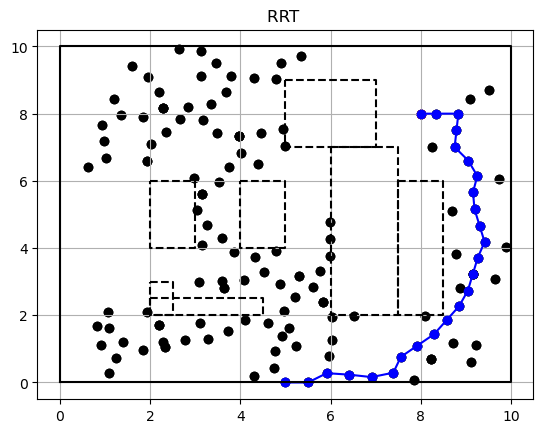

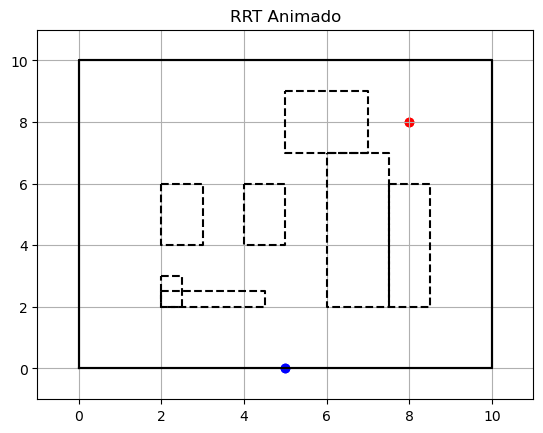

In [256]:
ejecutar_RRT()